In [1]:
# imports
import os
import seaborn as sns
from scipy import stats
from tqdm import tqdm

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import mode
from sklearn import metrics, preprocessing, model_selection
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline

In [3]:
import nltk
from nltk import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/mwapp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
import re
import string

from nltk.corpus import stopwords 
stop_words = stopwords.words('english')


import lightgbm as lgb
import matplotlib.pyplot as plt

%matplotlib inline

pd.options.display.max_columns = 100
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import warnings
warnings.filterwarnings("ignore")

In [7]:
sub_df = pd.read_excel('Sample_Submission.xlsx')

In [8]:
sub_df.head()

,Price
0,119
1,123
2,108
3,118
4,132


In [9]:
sub_df.shape

(1560, 1)

In [24]:
train_df = pd.read_excel('Data_Train.xlsx')

In [12]:
train_df.head(3)

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00


In [16]:
train_df['Edition'].value_counts().head(10)

Paperback,– 5 Oct 2017    48
Paperback,– 2016          46
Paperback,– 2017          36
Paperback,– 2013          31
Paperback,– 2019          30
Paperback,– 1 Jan 2013    27
Paperback,– 2012          22
Paperback,– 2015          21
Paperback,– 2014          20
Hardcover,– 2 Aug 2009    19
Name: Edition, dtype: int64

In [25]:
test_df = pd.read_excel('Data_Test.xlsx')

In [26]:
test_df.head(3)

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory
0,The Complete Sherlock Holmes: 2 Boxes sets,Sir Arthur Conan Doyle,"Mass Market Paperback,– 1 Oct 1986",4.4 out of 5 stars,960 customer reviews,A collection of entire body of work of the She...,Short Stories (Books),"Crime, Thriller & Mystery"
1,Learn Docker - Fundamentals of Docker 18.x: Ev...,Gabriel N. Schenker,"Paperback,– Import, 26 Apr 2018",5.0 out of 5 stars,1 customer review,Enhance your software deployment workflow usin...,Operating Systems Textbooks,"Computing, Internet & Digital Media"
2,Big Girl,Danielle Steel,"Paperback,– 17 Mar 2011",5.0 out of 5 stars,4 customer reviews,"'Watch out, world. Here I come!'\nFor Victoria...",Romance (Books),Romance


In [27]:
print(f'Number of samples in train: {train_df.shape[0]}')
print(f'Number of columns in train: {train_df.shape[1]}')
for col in train_df.columns:
    if train_df[col].isnull().any():
        print(col, train_df[col].isnull().sum())

Number of samples in train: 6237
Number of columns in train: 9


In [28]:
print(f'Number of samples in test: {test_df.shape[0]}')
print(f'Number of columns in test: {test_df.shape[1]}')
for col in test_df.columns:
    if test_df[col].isnull().any():
        print(col, test_df[col].isnull().sum())

Number of samples in test: 1560
Number of columns in test: 8


In [30]:
print(train_df.shape)
print(test_df.shape)

(6237, 9)
(1560, 8)


In [32]:
train_df.columns

Index(['Title', 'Author', 'Edition', 'Reviews', 'Ratings', 'Synopsis', 'Genre',
       'BookCategory', 'Price'],
      dtype='object')

WordCloud

In [33]:
from wordcloud import WordCloud, STOPWORDS

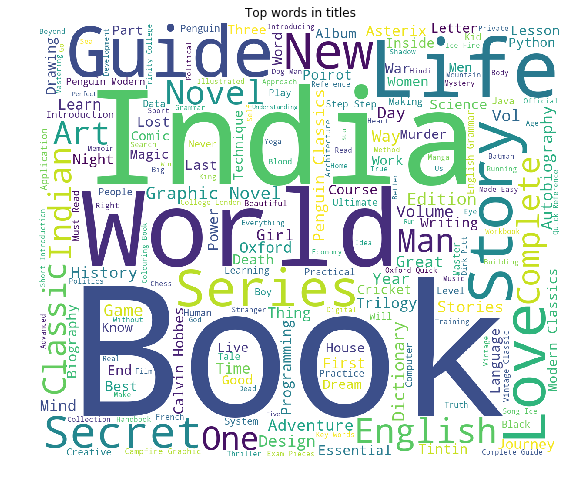

In [35]:
plt.figure(figsize = (12, 8))
text = ' '.join(train_df['Title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

In [36]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@[a-zA-Z0-9_]+', '', text)   
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)   
    text = re.sub(r'www.[^ ]+', '', text)  
    text = re.sub(r'[a-zA-Z0-9]*www[a-zA-Z0-9]*com[a-zA-Z0-9]*', '', text)  
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = [token for token in text.split() if len(token) > 2]
    text = ' '.join(text)
    return text

train_df['Synopsis'] = train_df['Synopsis'].apply(clean_text)
test_df['Synopsis'] = test_df['Synopsis'].apply(clean_text)

In [38]:
## Number of words in the Synopsis ##
train_df["Syn_num_words"] = train_df["Synopsis"].apply(lambda x: len(str(x).split()))
test_df["Syn_num_words"] = test_df["Synopsis"].apply(lambda x: len(str(x).split()))

In [49]:
fi = "hello world is not"

print(fi.split())

j = lambda x : len([w for w in str(fi).lower().split() if w in stop_words])

print(j(fi))

['hello', 'world', 'is', 'not']
2


In [39]:
## Number of unique words in the Synopsis ##
train_df["Syn_num_unique_words"] = train_df["Synopsis"].apply(lambda x: len(set(str(x).split())))
test_df["Syn_num_unique_words"] = test_df["Synopsis"].apply(lambda x: len(set(str(x).split())))

In [42]:
## Number of characters in the Synopsis ##
train_df["Syn_num_chars"] = train_df["Synopsis"].apply(lambda x: len(str(x)))
test_df["Syn_num_chars"] = test_df["Synopsis"].apply(lambda x: len(str(x)))

In [50]:
## Number of stopwords in the Synopsis ##
train_df["Syn_num_stopwords"]= train_df["Synopsis"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
test_df["Syn_num_stopwords"]= test_df["Synopsis"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

In [51]:
## Number of punctuations in the Synopsis ##
train_df["Syn_num_punctuations"] =train_df['Synopsis'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["Syn_num_punctuations"] =test_df['Synopsis'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

In [52]:
## Number of upper case words in the Synopsis ##
train_df["Syn_num_words_upper"] = train_df["Synopsis"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["Syn_num_words_upper"] = test_df["Synopsis"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

In [53]:
## Number of title case words in the Synopsis ##
train_df["Syn_num_words_title"] = train_df["Synopsis"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["Syn_num_words_title"] = test_df["Synopsis"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

In [54]:
## Average length of the words in the Synopsis ##
train_df["mean_word_len"] = train_df["Synopsis"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["Synopsis"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [55]:
## Number of words in the Title ##
train_df["Tit_num_words"] = train_df["Title"].apply(lambda x: len(str(x).split()))
test_df["Tit_num_words"] = test_df["Title"].apply(lambda x: len(str(x).split()))

## Number of unique words in the Title ##
train_df["Tit_num_unique_words"] = train_df["Title"].apply(lambda x: len(set(str(x).split())))
test_df["Tit_num_unique_words"] = test_df["Title"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the Title ##
train_df["Tit_num_chars"] = train_df["Title"].apply(lambda x: len(str(x)))
test_df["Tit_num_chars"] = test_df["Title"].apply(lambda x: len(str(x)))

## Number of stopwords in the Title ##
train_df["Tit_num_stopwords"] = train_df["Title"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
test_df["Tit_num_stopwords"] = test_df["Title"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

## Number of punctuations in the Title ##
train_df["Tit_num_punctuations"] =train_df['Title'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["Tit_num_punctuations"] =test_df['Title'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the Title ##
train_df["Tit_num_words_upper"] = train_df["Title"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["Tit_num_words_upper"] = test_df["Title"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the Title ##
train_df["Tit_num_words_title"] = train_df["Title"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["Tit_num_words_title"] = test_df["Title"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the Title ##
train_df["mean_word_len"] = train_df["Title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["Title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [56]:
# * join the datasets
train_df['is_train']  = 1
test_df['Price'] = 0
test_df['is_train'] = 0

In [57]:
full_df = train_df.append(test_df)

In [68]:
full_df.head()

,Author,BookCategory,Edition,Genre,Price,Ratings,Reviews,Syn_num_chars,Syn_num_punctuations,Syn_num_stopwords,Syn_num_unique_words,Syn_num_words,Syn_num_words_title,Syn_num_words_upper,Synopsis,Tit_num_chars,Tit_num_punctuations,Tit_num_stopwords,Tit_num_unique_words,Tit_num_words,Tit_num_words_title,Tit_num_words_upper,Title,is_train,mean_word_len,Edition_Type,Date,Year
0,Chris Kuzneski,Action & Adventure,"Paperback,– 10 Mar 2016",Action & Adventure (Books),220.00,8,4.0,705,0,37,87,112,0,0,the hunters return their third brilliant novel...,35,3,1,6,6,4,0,The Prisoner's Gold (The Hunters 3),1,5.000000,Paperback,10 Mar 2016,2016
1,Arun Khopkar,"Biographies, Diaries & True Accounts","Paperback,– 7 Nov 2012",Cinema & Broadcast (Books),202.93,14,3.9,1032,0,40,110,159,0,0,layered portrait troubled genius for whom art ...,34,1,2,7,7,6,1,Guru Dutt: A Tragedy in Three Acts,1,4.000000,Paperback,7 Nov 2012,2012
2,Thomas Hobbes,Humour,"Paperback,– 25 Feb 1982",International Relations,299.00,6,4.8,1482,0,66,157,211,0,0,during the time men live without common power ...,28,2,0,3,3,3,0,Leviathan (Penguin Classics),1,8.666667,Paperback,25 Feb 1982,1982
3,Agatha Christie,"Crime, Thriller & Mystery","Paperback,– 5 Oct 2017",Contemporary Fiction (Books),180.00,13,4.1,353,0,16,47,54,0,0,handful grain found the pocket murdered busine...,34,2,2,7,7,6,1,A Pocket Full of Rye (Miss Marple),1,4.000000,Paperback,5 Oct 2017,2017
4,Editors of Life,"Arts, Film & Photography","Hardcover,– 10 Oct 2006",Photography Textbooks,965.62,1,5.0,586,0,33,66,88,0,0,for seven decades life has been thrilling the ...,42,0,1,6,6,3,1,LIFE 70 Years of Extraordinary Photography,1,6.166667,Hardcover,10 Oct 2006,2006


In [59]:
full_df['Reviews'] = full_df['Reviews'].apply(lambda x: x.replace('out of 5 stars', ''))
full_df['Ratings'] = full_df['Ratings'].apply(lambda x: x.replace('customer reviews', ''))
full_df['Ratings'] = full_df['Ratings'].apply(lambda x: x.replace('customer review', ''))

In [65]:
full_df[['Edition_Type','Date']] = full_df.Edition.astype(str).str.split(",–", n = 1, expand = True)

In [67]:
full_df['Year'] = full_df['Date'].apply(lambda x: x[-5:] if x[-1].isdigit() else np.nan)

In [69]:
# code to find characters in string 
def find_chars(x):
  if(len(str(x))>0):
    return " ".join(re.split("[^a-zA-Z]*", x))
  else:
    return ""  

full_df['Month'] = full_df['Date'].apply(lambda x: find_chars(x))

def last_3_chars(x):
  if (len(x)>0):
    x = ''.join(x.split())
    return x[-3:]
  else:
    return ''

In [70]:
full_df['Month'] = full_df['Month'].apply(lambda x: last_3_chars(x))
full_df['Month'].value_counts()

Oct    795
Sep    696
May    668
Jan    637
Nov    625
Apr    605
Jun    605
Jul    580
Mar    574
Aug    544
Feb    508
Dec    503
       418
ort     15
set      7
ted      6
int      5
ion      2
ile      1
ged      1
TSC      1
ook      1
Name: Month, dtype: int64

In [72]:
def is_Paperback(x):
  if (str(x).find('Paperback') >-1):
    return 'Paperback'
  elif (str(x).find('Hardcover') >-1):
    return 'Hardcover'
  else:
    return 'Other'

In [73]:
full_df['Edition_Type'] = full_df['Edition_Type'].apply(lambda x: is_Paperback(x))

In [74]:
full_df['Edition_Type'].value_counts()

Paperback    6664
Hardcover    1056
Other          77
Name: Edition_Type, dtype: int64

In [75]:
testcount = len(test_df)
count = len(full_df)-testcount
print(count)

6237


In [76]:
full_df.shape

(7797, 29)

In [77]:
# Get Dummies
dfDummies = pd.get_dummies(full_df['BookCategory'], prefix = 'BookCategory')
full_df = pd.concat([full_df, dfDummies], axis=1)

dfDummies = pd.get_dummies(full_df['Edition_Type'], prefix = 'Edition_Type')
full_df = pd.concat([full_df, dfDummies], axis=1)


dfDummies = pd.get_dummies(full_df['Month'], prefix = 'Month')
full_df = pd.concat([full_df, dfDummies], axis=1)

In [78]:
# FinalData= FinalData.drop(cols,axis=1)
train = full_df[:count]
test = full_df[count:]
print(train.shape, test.shape)


train_df = train.copy()
test_df = test.copy()

(6237, 65) (1560, 65)


In [79]:
import re

trim_function = lambda x : re.findall("^\s*(.*?)\s*$",str(x))[0]

remove_commas = lambda x: re.sub("[^\d]", "", str(x))


train_df['Ratings']= train_df['Ratings'].apply(trim_function).apply(remove_commas).astype(int)
test_df['Ratings']= test_df['Ratings'].apply(trim_function).apply(remove_commas).astype(int)

train_df['Reviews']= train_df['Reviews'].apply(trim_function).apply(remove_commas).astype(int)
test_df['Reviews']= test_df['Reviews'].apply(trim_function).apply(remove_commas).astype(int)

In [80]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,4),max_features=200)
full_tfidf = tfidf_vec.fit_transform(train_df['Synopsis'].values.tolist() + test_df['Synopsis'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['Synopsis'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['Synopsis'].values.tolist())

In [83]:
train_tfidf = pd.DataFrame(train_tfidf.toarray(), columns=tfidf_vec.get_feature_names())
test_tfidf = pd.DataFrame(test_tfidf.toarray(), columns=tfidf_vec.get_feature_names())

train_df = pd.concat([train_df, train_tfidf], axis=1)
test_df = pd.concat([test_df, test_tfidf], axis=1)

Index(['Author', 'BookCategory', 'Edition', 'Genre', 'Price', 'Ratings',
       'Reviews', 'Syn_num_chars', 'Syn_num_punctuations', 'Syn_num_stopwords',
       ...
       'work', 'works', 'world', 'writing', 'written', 'year', 'years', 'york',
       'york times', 'young'],
      dtype='object', length=265)

In [98]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
train_df.head(3)

,Author,BookCategory,Edition,Genre,Price,Ratings,Reviews,Syn_num_chars,Syn_num_punctuations,Syn_num_stopwords,Syn_num_unique_words,Syn_num_words,Syn_num_words_title,Syn_num_words_upper,Synopsis,Tit_num_chars,Tit_num_punctuations,Tit_num_stopwords,Tit_num_unique_words,Tit_num_words,Tit_num_words_title,Tit_num_words_upper,Title,is_train,mean_word_len,Edition_Type,Date,Year,Month,BookCategory_Action & Adventure,"BookCategory_Arts, Film & Photography","BookCategory_Biographies, Diaries & True Accounts",BookCategory_Comics & Mangas,"BookCategory_Computing, Internet & Digital Media","BookCategory_Crime, Thriller & Mystery",BookCategory_Humour,"BookCategory_Language, Linguistics & Writing",BookCategory_Politics,BookCategory_Romance,BookCategory_Sports,Edition_Type_Hardcover,Edition_Type_Other,Edition_Type_Paperback,Month_,Month_Apr,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Month_TSC,Month_ged,Month_ile,Month_int,Month_ion,Month_ook,Month_ort,Month_set,Month_ted,account,adventure,age,american,art,author,available,award,away,based,beautiful,best,bestseller,bestselling,bestselling author,better,big,body,book,books,build,business,career,case,century,change,chapter,characters,child,children,city,classic,clear,collection,come,comes,complete,comprehensive,computer,concepts,country,course,create,dark,data,day,death,deep,design,different,does,easy,edition,end,english,essential,examples,exercises,experience,face,family,fans,father,features,film,finds,friends,future,game,girl,good,great,greatest,guide,heart,help,high,history,home,house,human,important,includes,including,india,indian,information,international,introduction,journey,just,key,king,know,knowledge,known,language,learn,learning,left,level,life,like,little,lives,long,look,love,make,makes,making,man,master,men,mind,modern,need,new,new york,new york times,novel,offers,old,original,page,past,people,perfect,personal,place,political,popular,power,powerful,practical,practice,programming,provides,published,questions,read,readers,reading,real,right,school,science,second,secret,secrets,self,series,set,shows,simple,skills,social,soon,step,stories,story,students,study,style,success,takes,tale,team,techniques,test,things,time,times,today,true,truth,understand,understanding,unique,use,used,using,various,volume,want,war,way,woman,women,words,work,works,world,writing,written,year,years,york,york times,young,10,2018,2019,adventures,album,answers,art,asterix,autobiography,batman,best,big,biography,black,book,books,business,calvin,calvin hobbes,cambridge,campfire,cat,cd,classic,classics,collection,college,collins,colouring,comics,complete,computer,course,creative,cricket,dark,data,day,days,death,design,dictionary,digital,dragon,drawing,easy,edition,english,essential,exam,film,game,girl,good,grade,grammar,graphic,graphic novel,graphic novels,great,greatest,guide,history,hobbes,house,ice,ielts,illustrated,india,indian,inside,international,introduction,jack,java,journey,key,know,language,learn,learning,level,library,life,like,little,lost,love,machine,magic,making,man,men,mind,modern,modern classics,music,new,night,novel,novels,official,omnibus,oxford,penguin,penguin classics,penguin modern,people,piano,poirot,power,practical,practice,programming,python,questions,read,red,reference,science,secret,secrets,self,series,set,short,step,stories,story,techniques,test,theory,things,time,times,tintin,training,trilogy,trinity,true,ultimate,vintage,vol,volume,war,way,women,words,world,writing,,(,a,an,b,c,f,i,l,m,o,of,of,p,s,t,th,the,the,w,(,),:,:,a,a,al,an,and,ar,at,b,c,d,d,de,e,e,ea,en,er,es,f,f,g,g,h,he,he,i,ic,in,ing,io,it,k,l,l,le,li,m,ma,n,n,nd,nd,ng,ng,nt,o,of,of,on,or,ou,p,r,r,ra,re,ri,ro,s,s,se,st,t,t,te,th,the,the,ti,to,u,v,ve,w,y,y,,a,an,and,and,b,c,d,e,f,h,l,m,p,s,t,th,the,the,w,a,al,an,and,and,ar,at,b,c,co,d,d,de,e,e,ea,ed,ed,en,er,er,es,es,f,g,g,h,ha,he,he,hi,i,in,ing,ing,is,it,k,l,l,le,li,ll,m,n,n,nd,nd,ne,ng,ng,nt,o,on,or,ou,p,r,r,ra,re,

In [94]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,4),max_features=150)
full_tfidf = tfidf_vec.fit_transform(train_df['Title'].values.tolist() + test_df['Title'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['Title'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['Title'].values.tolist())

In [95]:
train_tfidf = pd.DataFrame(train_tfidf.toarray(), columns=tfidf_vec.get_feature_names())
test_tfidf = pd.DataFrame(test_tfidf.toarray(), columns=tfidf_vec.get_feature_names())

train_df = pd.concat([train_df, train_tfidf], axis=1)
test_df = pd.concat([test_df, test_tfidf], axis=1)

In [96]:
### Fit transform the CountVectorizer ###
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char', max_features=100)
tfidf_vec.fit(train_df['Title'].values.tolist() + test_df['Title'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['Title'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['Title'].values.tolist())


train_tfidf = pd.DataFrame(train_tfidf.toarray(), columns=tfidf_vec.get_feature_names())
test_tfidf = pd.DataFrame(test_tfidf.toarray(), columns=tfidf_vec.get_feature_names())

train_df = pd.concat([train_df, train_tfidf], axis=1)
test_df = pd.concat([test_df, test_tfidf], axis=1)

In [97]:
### Fit transform the CountVectorizer ###
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char', max_features=100)
tfidf_vec.fit(train_df['Synopsis'].values.tolist() + test_df['Synopsis'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['Synopsis'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['Synopsis'].values.tolist())


train_tfidf = pd.DataFrame(train_tfidf.toarray(), columns=tfidf_vec.get_feature_names())
test_tfidf = pd.DataFrame(test_tfidf.toarray(), columns=tfidf_vec.get_feature_names())

train_df = pd.concat([train_df, train_tfidf], axis=1)
test_df = pd.concat([test_df, test_tfidf], axis=1)

In [101]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('glove.840B.300d.txt', encoding='utf8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196018it [05:29, 6665.01it/s]

Found 2196017 word vectors.


In [105]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [106]:
# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(train_df['Synopsis'].values)]
xtest_glove = [sent2vec(x) for x in tqdm(test_df['Synopsis'].values)]

100%|██████████| 1560/1560 [00:02<00:00, 575.05it/s]


In [107]:
xtrain_glove = np.array(xtrain_glove)
xtest_glove = np.array(xtest_glove)

xtrain_glove = pd.DataFrame(xtrain_glove)
xtest_glove = pd.DataFrame(xtest_glove)

print(xtrain_glove.shape)

(6237, 300)


In [108]:
xtrain_glove.columns = ['glove_syn_'+str(i) for i in range(300)]
xtest_glove.columns = ['glove_syn_'+str(i) for i in range(300)]

train_df = pd.concat([train_df, xtrain_glove], axis=1)
test_df = pd.concat([test_df, xtest_glove], axis=1)


In [110]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf8')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


400000it [00:25, 15831.79it/s]

Found 400000 word vectors.


In [111]:
# this function creates a normalized vector for the whole sentence
def sent2vec_genre(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(100)
    return v / np.sqrt((v ** 2).sum())

In [112]:
# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec_genre(x) for x in tqdm(train_df['Genre'].values)]
xtest_glove = [sent2vec_genre(x) for x in tqdm(test_df['Genre'].values)]

xtrain_glove = np.array(xtrain_glove)
xtest_glove = np.array(xtest_glove)

xtrain_glove = pd.DataFrame(xtrain_glove)
xtest_glove = pd.DataFrame(xtest_glove)

print(xtrain_glove.shape)

xtrain_glove.columns = ['glove_genre_'+str(i) for i in range(100)]
xtest_glove.columns = ['glove_genre_'+str(i) for i in range(100)]

train_df = pd.concat([train_df, xtrain_glove], axis=1)
test_df = pd.concat([test_df, xtest_glove], axis=1)

100%|██████████| 1560/1560 [00:00<00:00, 2799.66it/s]


(6237, 100)


In [114]:
# this function creates a normalized vector for the whole sentence
def sent2vec_bk(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(100)
    return v / np.sqrt((v ** 2).sum())

# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec_bk(x) for x in tqdm(train_df['BookCategory'].values)]
xtest_glove = [sent2vec_bk(x) for x in tqdm(test_df['BookCategory'].values)]

xtrain_glove = np.array(xtrain_glove)
xtest_glove = np.array(xtest_glove)

xtrain_glove = pd.DataFrame(xtrain_glove)
xtest_glove = pd.DataFrame(xtest_glove)

print(xtrain_glove.shape)

xtrain_glove.columns = ['glove_bc_'+str(i) for i in range(100)]
xtest_glove.columns = ['glove_bc_'+str(i) for i in range(100)]

train_df = pd.concat([train_df, xtrain_glove], axis=1)
test_df = pd.concat([test_df, xtest_glove], axis=1)

100%|██████████| 1560/1560 [00:00<00:00, 2873.54it/s]


(6237, 100)


In [115]:
cols = ['Title', 'Author',   'Synopsis', 'Genre',
#        'BookCategory', 'Edition_Type',
        'Year', 'Month'
       ]
for col in cols:
    if train_df[col].dtype==object:
        print(col)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
        train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
        test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

Title
Author
Synopsis
Genre
Year
Month


Text(0.5,1,'Distribution of log of revenue')

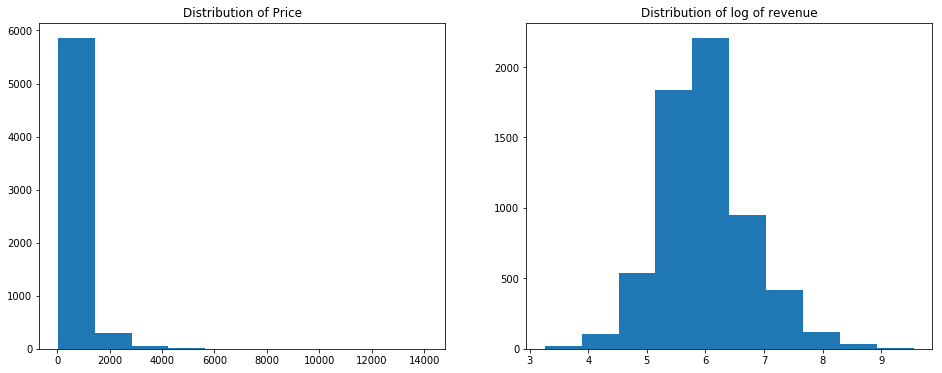

In [116]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train_df['Price'])
plt.title('Distribution of Price')
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train_df['Price']))
plt.title('Distribution of log of revenue')

In [117]:
train_df['id'] = range(0, 0+len(train_df))
test_df['id'] = range(0, 0+len(test_df))

In [119]:
## Count features
for col in ['Author', 'BookCategory', 'Edition', 'Genre',  'Ratings',
          'Reviews',         
            ['Author', 'BookCategory'], 
            ['Author', 'Edition'], 
            ['Author', 'Genre'],
            ['Author', 'Ratings'],
            ['Author', 'Reviews'],]:
    if not isinstance(col, list):
        col = [col]
    col_name = "_".join(col)
    all_df = pd.concat([train_df[["id"]+ col], test_df[["id"]+ col]])
    gdf = all_df.groupby(col)["id"].count().reset_index()
    gdf.columns = col + [col_name+"_count"]
    train_df = pd.merge(train_df, gdf, on=col, how="left")
    test_df = pd.merge(test_df, gdf, on=col, how="left")

In [118]:
train_df['log_Price'] = np.log1p(train_df['Price'])
test_df['log_Price'] = np.log1p(test_df['Price'])

In [120]:
print(train_df.shape, test_df.shape)

(6237, 1128) (1560, 1128)


In [121]:
class renamer():
  def __init__(self):
    self.d = dict()

  def __call__(self, x):
    if x not in self.d:
      self.d[x] = 0
      return x
    else:
      self.d[x] += 1
      return "%s_%d" % (x, self.d[x])

In [123]:
train_df.rename(columns=renamer(), inplace=True)

In [124]:
train_df.columns

Index(['Author', 'BookCategory', 'Edition', 'Genre', 'Price', 'Ratings',
       'Reviews', 'Syn_num_chars', 'Syn_num_punctuations', 'Syn_num_stopwords',
       ...
       'BookCategory_count', 'Edition_count', 'Genre_count', 'Ratings_count',
       'Reviews_count', 'Author_BookCategory_count', 'Author_Edition_count',
       'Author_Genre_count', 'Author_Ratings_count', 'Author_Reviews_count'],
      dtype='object', length=1128)

In [125]:
test_df.rename(columns=renamer(), inplace=True)

In [126]:
def mean_likelihood(df, cat_var, target, alpha = 0.5):
    P_c = df.groupby(cat_var)[target].transform('mean')
    P_global = df[target].mean()
    n_c = df.groupby(cat_var)[target].transform('count')
    enc = (P_c*n_c + P_global*alpha)/(n_c + alpha)
    temp = df[[cat_var]]
    temp['enc'] = enc
    return temp.groupby(cat_var).mean()

In [127]:
cat_vars = ['Author', 'Genre', 'Ratings', 'Reviews', 'BookCategory', 'Edition_Type', 'Year', 'Month']
# getting mean encoding features
cvlist = list(KFold(n_splits = 10, random_state = 1).split(train_df))
for var in cat_vars:
    mean_enc_var = np.zeros(len(train_df))
    for tr_idx, val_idx in cvlist:
        X_tr, X_val = train_df.loc[tr_idx], train_df.loc[val_idx]
        X_tr_mean = mean_likelihood(X_tr, var, 'log_Price')
        mean_enc_var[val_idx] = X_val[var].map(X_tr_mean['enc'])
        train_df[f'mean_enc_{var}'] = mean_enc_var
    train_df[f'mean_enc_{var}'] = train_df[f'mean_enc_{var}'].fillna(train_df[f'mean_enc_{var}'].mean())
    test_df[f'mean_enc_{var}'] = test_df[var].map(mean_likelihood(train_df, 
                                                                    var, 'log_Price')['enc'])
    test_df[f'mean_enc_{var}'] = test_df[f'mean_enc_{var}'].fillna(train_df[f'mean_enc_{var}'].mean())

Model

In [128]:
train_X = train_df.drop(['is_train','Price', 'log_Price','Synopsis','Title', 'Date', 'Edition', 'BookCategory', 'Edition_Type',  'Month','id'],axis=1)
test_X = test_df.drop(['is_train', 'Price', 'log_Price', 'Synopsis', 'Title','Date', 'Edition','BookCategory', 'Edition_Type',  'Month', 'id'],axis=1)
y = (train_df['log_Price'])
train_y = y


X = train_X

In [129]:
def runLGB(train_X, train_y, test_X, test_y=None, test_X2=None): 
    params = {}
    params["objective"] = "regression"
    params['metric'] = 'rmse'
    params["max_depth"] = 8
    params["min_data_in_leaf"] = 1
    params["learning_rate"] = 0.0025
    params["bagging_fraction"] = 0.8
    params["feature_fraction"] = 0.8
    params["bagging_freq"] = 5
    params["bagging_seed"] = 0
    params["verbosity"] = -1
    num_rounds = 20000

    plst = list(params.items())
    lgtrain = lgb.Dataset(train_X, label=train_y)

    if test_y is not None:
        lgtest = lgb.Dataset(test_X, label=test_y)
        model = lgb.train(params, lgtrain,  num_rounds, valid_sets=[lgtest], 
                          early_stopping_rounds=200, verbose_eval=1000)
    else:
        lgtest = lgb.Dataset(test_X)
        model = lgb.train(params, lgtrain,   num_rounds)

    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)

    loss = 0
    if test_y is not None:
        loss = np.sqrt(metrics.mean_squared_error(test_y, pred_test_y))
        print(loss)
        return pred_test_y, loss, pred_test_y2, model
    else:
        return pred_test_y, loss, pred_test_y2, model

In [133]:
cv_scores = []
pred_test_full = 0
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=30)
for dev_index, val_index in kf.split(X, y):  
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    pred_val, loss, pred_test,model = runLGB(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_full += pred_test
    cv_scores.append(loss)
    print(cv_scores)
pred_test_full /= 5.
print(sum(cv_scores)/5)

Training until validation scores don't improve for 200 rounds
[1000]	valid_0's rmse: 0.521834
[2000]	valid_0's rmse: 0.497002
[3000]	valid_0's rmse: 0.489657
[4000]	valid_0's rmse: 0.485862
[5000]	valid_0's rmse: 0.483896
[6000]	valid_0's rmse: 0.482469
[7000]	valid_0's rmse: 0.481528
[8000]	valid_0's rmse: 0.480792
[9000]	valid_0's rmse: 0.480113
[10000]	valid_0's rmse: 0.479737
[11000]	valid_0's rmse: 0.479275
[12000]	valid_0's rmse: 0.478995
Early stopping, best iteration is:
[12544]	valid_0's rmse: 0.478855
0.4788549604146338
[0.4788549604146338]
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's rmse: 0.498247
[2000]	valid_0's rmse: 0.47744
[3000]	valid_0's rmse: 0.471469
[4000]	valid_0's rmse: 0.468396
[5000]	valid_0's rmse: 0.466435
[6000]	valid_0's rmse: 0.464918
[7000]	valid_0's rmse: 0.464149
[8000]	valid_0's rmse: 0.463478
[9000]	valid_0's rmse: 0.463198
Early stopping, best iteration is:
[9184]	valid_0's rmse: 0.463147
0.4631469190940995
[0.47885

In [135]:
# # Fill the is_pass variable with the predictions
sub_df['Price']= pd.DataFrame(np.exp(pred_test_full))

# # Converting the submission file to excel format
sub_df.to_excel('lgb_101_bs_0_lr_0p0025_final_2.xlsx', index=False)

In [137]:
import pickle
pickle.dump(model, open('final_prediction.pickle', 'wb'))

In [142]:
test_X.head(1).to_csv('test_sample.csv')

In [143]:
test_data = pd.read_csv('test_sample.csv')

In [144]:
test_list = [list(test_data.iloc[0])]